In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook

In [2]:
community_size = 3

D_min = [0.0,0.0,0.0]
D_max = [10.0,10.0,10.0]

G_min = [0.0,0.0,0.0]
G_max = [10.0,0.0,0.0]

Kappa = [[0.0, 10.0, 10.0],
            [10.0, 0.0, 5.0],
            [10.0, 5.0, 0.0]]

Cost = [[0.0, -1.0, 1.0],
        [3.0, 0.0, 1.0],
        [2.0, 1.0, 0.0]]

probabilities = [0.5, 0.5]

#probabilities = [1]
connection_matrix = [[0,1,1],[1,0,1],[1,1,0]]

In [3]:
import random

A_tilde = [random.uniform(0,1) for i in range(community_size)]
B_tilde = [random.uniform(0,1) for i in range(community_size)]

a = [random.uniform(0,1) for i in range(community_size)]
b = [random.uniform(0,1) for i in range(community_size)]
d = [random.uniform(0,1) for i in range(community_size)]

d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

g_res = np.array(g_res)
d_target = np.array(d_target)

risk_aversion = [random.uniform(0,1) for i in range(community_size)]

In [4]:
from supplement_package.game.torch_grad import TorchPlayer, BasicFunctions, RiskProblemFunctions

agents = []

TorchPlayer.community_size = community_size

epsilon = 0.05
alpha = [[proba/(1 - min(risk_aversion)) - epsilon for proba in probabilities] for i in range(community_size)]
#alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
#alpha = [proba/(1 - min(risk_aversion)) for proba in probabilities]
gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

j_max = [5 for i in range(community_size)]

for i in range(community_size):
    agent = TorchPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                probabilities = probabilities,
                alpha = alpha[i], 
                gamma = gamma, 
                insurance_bound=j_max[i])
    
    agents.append(agent)

In [5]:
import gurobipy as gp
from supplement_package.gurobi_implementation.gurobi import Gurobi
from supplement_package.gurobi_implementation.gurobi import GurobiSolution

In [6]:
model_1 = gp.Model()
setup = GurobiSolution(agents=agents,
                model = model_1,
                solution_type='centralized')

setup.build_model()

model_1.display()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-02
Minimize
<gurobi.LinExpr: eta_0 + 0.6101304882529093 W_0_0 + 0.6101304882529093 W_0_1
+ 0.5601304882529092 J_0_0 + 0.5601304882529092 J_0_1 + 0.6101304882529093 u_0_0
+ 0.6101304882529093 u_0_1 + eta_1 + 0.6101304882529093 W_1_0 + 0.6101304882529093 W_1_1
+ 0.5601304882529092 J_1_0 + 0.5601304882529092 J_1_1 + 0.9789507980826849 u_1_0
+ 0.9789507980826849 u_1_1 + eta_2 + 0.6101304882529093 W_2_0 + 0.6101304882529093 W_2_1
+ 0.5601304882529092 J_2_0 + 0.5601304882529092 J_2_1 + 1.1319973509720638 u_2_0
+ 1.1319973509720638 u_2_1>
Subject To
  Bilateral trading for pair (0, 1) proba 0: <gurobi.LinExpr: q_0_1_0 + q_1_0_0> = 0
  Bilateral trading for pair (0, 1) proba 1: <gurobi.LinExpr: q_0_1_1 + q_1_0_1> = 0
  Bilateral trading for pair (0, 2) proba 0: <gurobi.LinExpr: q_0_2_0 + q_2_0_0> = 0
  Bilateral trading for pair (0, 2) proba 1: <gurobi.LinExpr: q_0_2_1 + q_2_0_1> = 0
SD balance for agent 0 

In [7]:
model_1.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 45 columns and 54 nonzeros
Model fingerprint: 0x8d68457b
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-02, 9e-01]
  QLMatrix range   [7e-03, 1e+01]
  Objective range  [6e-01, 1e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e-01, 3e+00]
  QRHS range       [5e-01, 5e+01]
Presolve removed 6 rows and 4 columns
Presolve time: 0.00s
Presolved: 42 rows, 53 columns, 116 nonzeros
Presolved model has 6 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 1.150e+02
 Factor NZ  : 3.820e+02
 Factor Ops : 4.458e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.0738655

In [8]:
model_1 = gp.Model()
setup = GurobiSolution(agents=agents,
                model = model_1,
                solution_type='quadratic_test')

setup.build_model()

model_1.display()

Minimize
<gurobi.QuadExpr: 0.0 + [ 0.6101304882529093 W_0_0 ^ 2 + 0.6101304882529093 W_0_1 ^ 2
+ 0.5601304882529092 J_0_0 ^ 2 + 0.5601304882529092 J_0_1 ^ 2
+ 0.6101304882529093 u_0_0 ^ 2 + 0.6101304882529093 u_0_1 ^ 2
+ 0.6101304882529093 W_1_0 ^ 2 + 0.6101304882529093 W_1_1 ^ 2
+ 0.5601304882529092 J_1_0 ^ 2 + 0.5601304882529092 J_1_1 ^ 2
+ 0.9789507980826849 u_1_0 ^ 2 + 0.9789507980826849 u_1_1 ^ 2
+ 0.6101304882529093 W_2_0 ^ 2 + 0.6101304882529093 W_2_1 ^ 2
+ 0.5601304882529092 J_2_0 ^ 2 + 0.5601304882529092 J_2_1 ^ 2
+ 1.1319973509720638 u_2_0 ^ 2 + 1.1319973509720638 u_2_1 ^ 2 ]>
Subject To
  Bilateral trading for pair (0, 1) proba 0: <gurobi.LinExpr: q_0_1_0 + q_1_0_0> = 0
  Bilateral trading for pair (0, 1) proba 1: <gurobi.LinExpr: q_0_1_1 + q_1_0_1> = 0
  Bilateral trading for pair (0, 2) proba 0: <gurobi.LinExpr: q_0_2_0 + q_2_0_0> = 0
  Bilateral trading for pair (0, 2) proba 1: <gurobi.LinExpr: q_0_2_1 + q_2_0_1> = 0
SD balance for agent 0 proba 0: <gurobi.LinExpr: D_0_0 

In [9]:
model_1.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 45 columns and 54 nonzeros
Model fingerprint: 0x2f0c7f3c
Model has 18 quadratic objective terms
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-02, 9e-01]
  QLMatrix range   [7e-03, 1e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e-01, 3e+00]
  QRHS range       [5e-01, 5e+01]
Presolve removed 6 rows and 4 columns
Presolve time: 0.00s
Presolved: 61 rows, 55 columns, 136 nonzeros
Presolved model has 7 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 Free vars  : 3
 AA' NZ     : 1.660e+02
 Factor NZ  : 5.500e+02
 Factor Ops : 5.796e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

In [10]:
lr = 1e-2
rho = 1500

vars = []
with torch.no_grad():
    for agent in agents:
        vars += [agent.G, agent.D, agent.q, agent.w, agent.j, agent.u, agent.eta]

#torch.autograd.set_detect_anomaly(True)
    
optimizer = optim.Adam(vars, lr = lr)

for i in tqdm_notebook(range(50000)):
    for agent in agents:
        
        utility = RiskProblemFunctions.risk_utility_per_proba(agent)
        penalty_SD_balance = BasicFunctions.penalty_SD_balance(agent)
        penalty_demand_bounds_lower = BasicFunctions.penalty_demand_bounds_lower(agent)
        penalty_demand_bounds_upper = BasicFunctions.penalty_demand_bounds_upper(agent)
        penalty_generation_bounds_lower = BasicFunctions.penalty_generation_bounds_lower(agent)
        penalty_generation_bounds_upper = BasicFunctions.penalty_generation_bounds_upper(agent)
        penalty_trading_bound_lower = BasicFunctions.penalty_trading_bound_lower(agent)
        penalty_trading_bound_upper = BasicFunctions.penalty_trading_bound_upper(agent)
        penalty_bilateral_trading_bounds = BasicFunctions.penalty_bilateral_trading_bounds(agent)

        insurance_bound_lower = RiskProblemFunctions.insurance_bound_lower(agent)
        insurance_bound_upper = RiskProblemFunctions.insurance_bound_upper(agent)
        contract_trading_bound = RiskProblemFunctions.contract_trading_bound(agent)
        residual_bound = RiskProblemFunctions.residual_bound(agent)
        penalty_residual = RiskProblemFunctions.penalty_residual(agent)


        loss = 0
        loss += agent.eta
        

        for proba in agent.probabilities_ind:
            loss += (utility[proba]
                + rho * penalty_SD_balance[proba]
                + rho * penalty_demand_bounds_lower[proba]
                + rho * penalty_demand_bounds_upper[proba]
                + rho * penalty_generation_bounds_lower[proba]
                + rho * penalty_generation_bounds_upper[proba]
                + rho * insurance_bound_lower[proba]
                + rho * insurance_bound_lower[proba]
                + rho * contract_trading_bound[proba]
                + rho * residual_bound[proba]
                + rho * penalty_residual[proba])

            for agent_2, connection in enumerate(agent.connections):
                if connection:
                    loss += (rho * penalty_trading_bound_lower[agent_2][proba]
                            + rho * penalty_trading_bound_upper[agent_2][proba]
                            + rho * penalty_bilateral_trading_bounds[agent_2][proba])

        loss.backward()

        optimizer.step()
        with torch.no_grad():
            agent.plot_eta.append(agent.eta.data.numpy())

            for proba in agent.probabilities_ind:
                    agent.plot_d[proba].append(agent.D.data.numpy()[proba])
                    agent.plot_g[proba].append(agent.G.data.numpy()[proba])
                    agent.plot_j[proba].append(agent.j.data.numpy()[proba])
                    agent.plot_w[proba].append(agent.w.data.numpy()[proba])
                    agent.plot_u[proba].append(agent.u.data.numpy()[proba])
                    
                    for agent_2 in agents:
                        agent.plot_q[agent_2.id][proba].append(agent.q.data.numpy()[agent_2.id][proba])

        optimizer.zero_grad()

    for agent in agents:      
        for agent_2 in agents:
            #for proba in agent.probabilities_ind:
            agent_2.q_others[agent.id] = agent.q.data.numpy().tolist()
            agent_2.w_others[agent.id] = agent.w.data.numpy().tolist()

  0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
total_cost = 0
with torch.no_grad():
    for agent in agents:
        total_cost += sum(BasicFunctions.utility(agent))

total_cost


tensor(5.5795, dtype=torch.float64)

In [12]:
model_1.ObjVal

2.1867845628742444e-07

In [13]:
model_1.getVars()

[<gurobi.Var D_0_0 (value 3.369290592510313)>,
 <gurobi.Var D_0_1 (value 4.3700693488059565)>,
 <gurobi.Var G_0_0 (value 5.53249323527316)>,
 <gurobi.Var G_0_1 (value 4.852547471849449)>,
 <gurobi.Var q_0_1_0 (value -1.6845592644795708)>,
 <gurobi.Var q_0_1_1 (value -1.2582035068617419)>,
 <gurobi.Var q_0_2_0 (value -2.030909797686811)>,
 <gurobi.Var q_0_2_1 (value -2.0350094889875505)>,
 <gurobi.Var eta_0 (value 41.36840673114118)>,
 <gurobi.Var W_0_0 (value -2.3378450402982138e-07)>,
 <gurobi.Var W_0_1 (value -2.035001593460228e-07)>,
 <gurobi.Var J_0_0 (value 0.00019607548458841758)>,
 <gurobi.Var J_0_1 (value 0.00019317058710011884)>,
 <gurobi.Var u_0_0 (value 2.3135808167596116e-05)>,
 <gurobi.Var u_0_1 (value 4.4858928940388204e-05)>,
 <gurobi.Var D_1_0 (value 2.3543456022074576)>,
 <gurobi.Var D_1_1 (value 4.214979752043226)>,
 <gurobi.Var G_1_0 (value 0.0)>,
 <gurobi.Var G_1_1 (value 0.0)>,
 <gurobi.Var q_1_0_0 (value 1.684559264479578)>,
 <gurobi.Var q_1_0_1 (value 1.258203506

In [14]:
optimizer.param_groups

[{'params': [tensor([1.1321, 2.3328], requires_grad=True),
   tensor([3.6340, 4.8578], requires_grad=True),
   tensor([[ 0.0000,  0.0000],
           [ 2.1335,  3.1600],
           [-1.1839, -3.4442]], requires_grad=True),
   tensor([ 0.0065, -0.0108], dtype=torch.float64, requires_grad=True),
   tensor([0., 0.], dtype=torch.float64, requires_grad=True),
   tensor([0.2202, 0.6364], requires_grad=True),
   tensor(-2.1673, dtype=torch.float64, requires_grad=True),
   tensor([ 2.5005e-05, -1.0530e-03], requires_grad=True),
   tensor([1.5127e-03, 4.2280e+00], requires_grad=True),
   tensor([[-2.1335, -3.1602],
           [ 0.0000,  0.0000],
           [ 1.9437,  4.9967]], requires_grad=True),
   tensor([-0.1387,  0.1466], dtype=torch.float64, requires_grad=True),
   tensor([0., 0.], dtype=torch.float64, requires_grad=True),
   tensor([2.8026e-45, 5.1147e-01], requires_grad=True),
   tensor(6.8030, dtype=torch.float64, requires_grad=True),
   tensor([3.6969e-05, 1.0224e-03], requires_grad=T

In [15]:
for agent in agents:
    print(np.array(list(agent.w_others.values())))
    print(agent.w)

[[ 0.00654815 -0.01081596]
 [-0.1387339   0.14664481]
 [ 0.12284389 -0.13092731]]
tensor([ 0.0065, -0.0108], dtype=torch.float64, requires_grad=True)
[[ 0.00654815 -0.01081596]
 [-0.1387339   0.14664481]
 [ 0.12284389 -0.13092731]]
tensor([-0.1387,  0.1466], dtype=torch.float64, requires_grad=True)
[[ 0.00654815 -0.01081596]
 [-0.1387339   0.14664481]
 [ 0.12284389 -0.13092731]]
tensor([ 0.1228, -0.1309], dtype=torch.float64, requires_grad=True)


In [16]:
def contract_trading_bound(agent: TorchPlayer) -> list:
    res = [torch.tensor(0, dtype=float) for proba in agent.probabilities_ind]

    for proba in agent.probabilities_ind:
        res[proba] = sum(np.array(list(agent.w_others.values())).T[proba]) ** 2 

    return res

In [17]:
for agent in agents:
    print(contract_trading_bound(agent))

[8.727045085449887e-05, 2.40252042650567e-05]
[8.727045085449887e-05, 2.40252042650567e-05]
[8.727045085449887e-05, 2.40252042650567e-05]


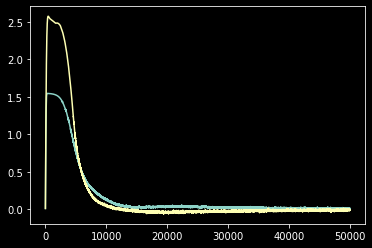

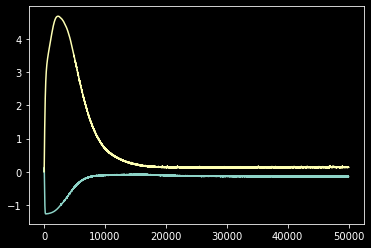

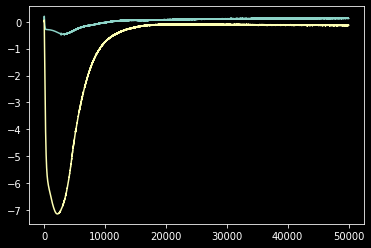

In [18]:
for agent in agents:
    for proba in agent.probabilities_ind:
        plt.plot(agent.plot_w[proba])
    plt.show()

In [19]:
for agent in agents:
    for proba in agent.probabilities_ind:
        print(agent.w[proba] - agent.u[proba])

tensor(-0.2137, dtype=torch.float64, grad_fn=<SubBackward0>)
tensor(-0.6472, dtype=torch.float64, grad_fn=<SubBackward0>)
tensor(-0.1387, dtype=torch.float64, grad_fn=<SubBackward0>)
tensor(-0.3648, dtype=torch.float64, grad_fn=<SubBackward0>)
tensor(0.0342, dtype=torch.float64, grad_fn=<SubBackward0>)
tensor(-0.4591, dtype=torch.float64, grad_fn=<SubBackward0>)


In [20]:
if (i >=0 for i in range(-2,2)):
    print(i)

49999


In [21]:
for i in range(-2,2):
    print(i)

-2
-1
0
1
